# Create PFT Grids
This notebooks creates PFT "dominant" and "co-dominant" grids from a surface dataset.

In [1]:
import os

import xarray as xr
import pandas as pd
import numpy as np

import fates_calibration_library.surface_data_functions as surface
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.utils as utils
import fates_calibration_library.plotting_functions as plotting

In [ ]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

In [ ]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

In [10]:
# surface file
surdat_dir = "/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/"
surdat_2deg = os.path.join(surdat_dir, "surfdata_1.9x2.5_hist_2000_16pfts_c240908.nc")

# fates-clm index mapping
fates_clm_mapping_file = os.path.join("/glade/work/afoster/FATES_calibration",
                                      "scripts/fates_calibration_library",
                                      "fates_clm_index.yaml")
fates_clm_mapping = utils.get_config_file(fates_clm_mapping_file)

# ilamb observations
ILAMB_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')
ilamb_config_file = '/glade/work/afoster/FATES_calibration/scripts/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)

# LAI - for subsetting out desert, etc. grids
lai = ilamb.average_obs_across_models(ILAMB_obs, ['AVH15C1', 'AVHRR'], 'lai')

# whittaker biomes
biome = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker_biomes_2deg.nc')

# pft names
param = xr.open_dataset(os.path.join('/glade/work/afoster/FATES_calibration/parameter_files',
                        'fates_params_default_sci.1.81.1_api.38.0.0_crops_vai.nc'))
pft_names = [str(f).replace("b'", "").strip().replace(" ", "").replace("'", "") for f in param.fates_pftname.values]

# where to place grids
out_dir = '/glade/work/afoster/FATES_calibration/mesh_files'

## Read in surface dataset
Create LAI DataArray for subsetting out low LAI grids

In [3]:
surdat = surface.get_surdat(surdat_2deg)
lai_interp = lai.interp(lat=surdat['lat'], lon=surdat['lon'])

## Create Dominant Grids

In [ ]:
dominant_grid = surface.extract_dominant_grids(surdat, lai, fates_clm_mapping)

### Filter on uncertain observations

In [ ]:
dominant_df = ilamb.extract_ilamb_obs(ILAMB_obs, dominant_grid, biome, ilamb_config, 
                                      {'filter_vars': ['le', 'sh', 'gpp', 'ef'],
                                       'tol': 6.0})
dominant_df.to_csv(os.path.join(out_dir, 'dominant_grid.csv'))

### Create the mask dataset

In [ ]:
num_gridcells, surdat_dom = surface.create_mask_ds(surdat, dominant_df, pft_names)
print(f"Made a surface dataset with {num_gridcells} gridcells")
surface.write_landmask(surdat_dom, out_dir, 'dominant')

In [ ]:
plotting.plot_pft_grids(surdat_dom, pft_names, "Dominant Grids")

## Create Co-Dominant Grids

In [13]:
dom_thresh = {"broadleaf_evergreen_tropical_tree": 75,
              "needleleaf_evergreen_extratrop_tree": 75,
              "needleleaf_colddecid_extratrop_tree": 75,
              "broadleaf_evergreen_extratrop_tree": 30,
              "broadleaf_hydrodecid_tropical_tree": 30,
              "broadleaf_colddecid_extratrop_tree": 30,
              "broadleaf_evergreen_extratrop_shrub": 30,
              "broadleaf_hydrodecid_extratrop_shrub": 60,
              "broadleaf_colddecid_extratrop_shrub": 60,
              "broadleaf_evergreen_arctic_shrub": 60,
              "broadleaf_colddecid_arctic_shrub": 60,
              "arctic_c3_grass": 75,
              "cool_c3_grass": 75,
              "c4_grass": 75,
              "c3_crop": 60,
              "c3_irrigated": 30}

In [14]:
dom_pft_file = os.path.join(out_dir, 'dominant_grid.csv')
dom_pfts = np.unique(pd.read_csv(dom_pft_file).pft.values)

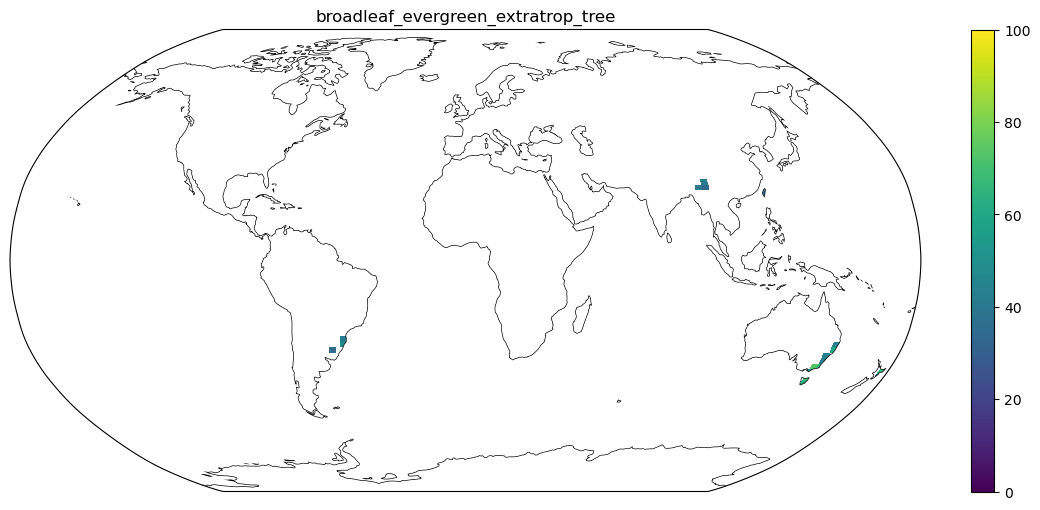

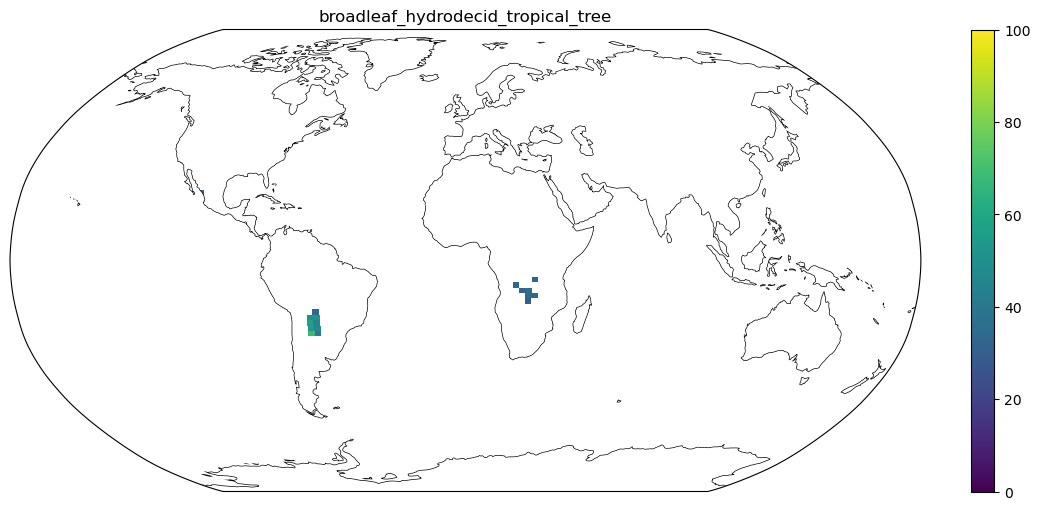

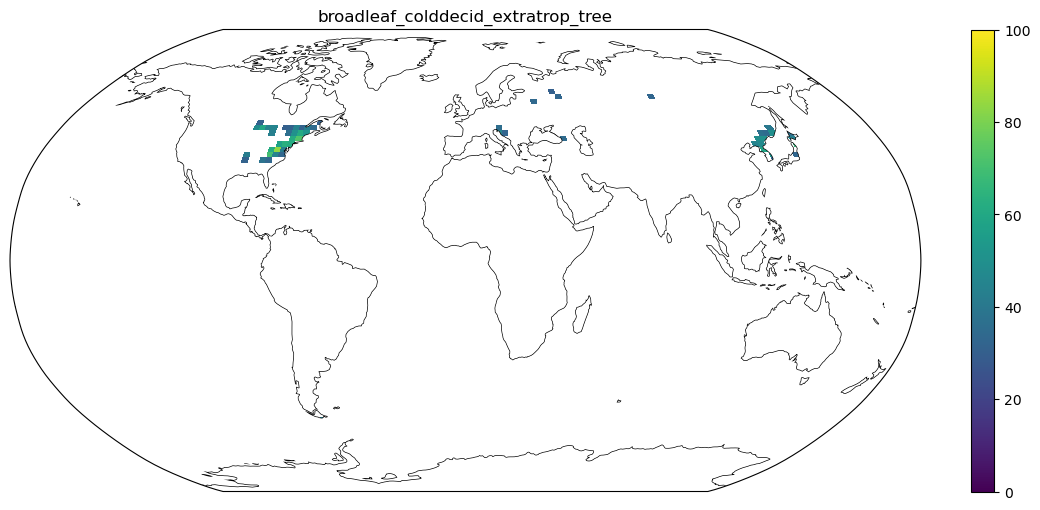

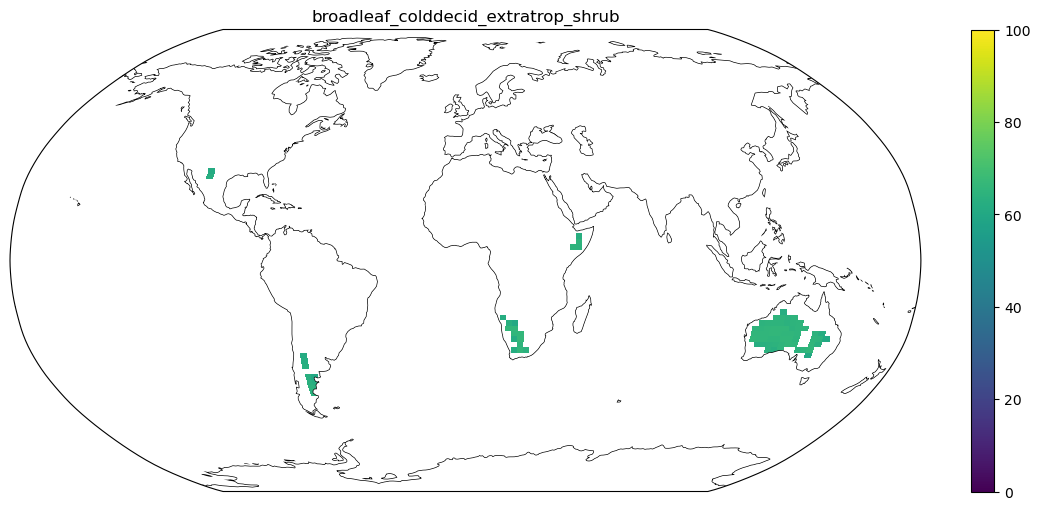

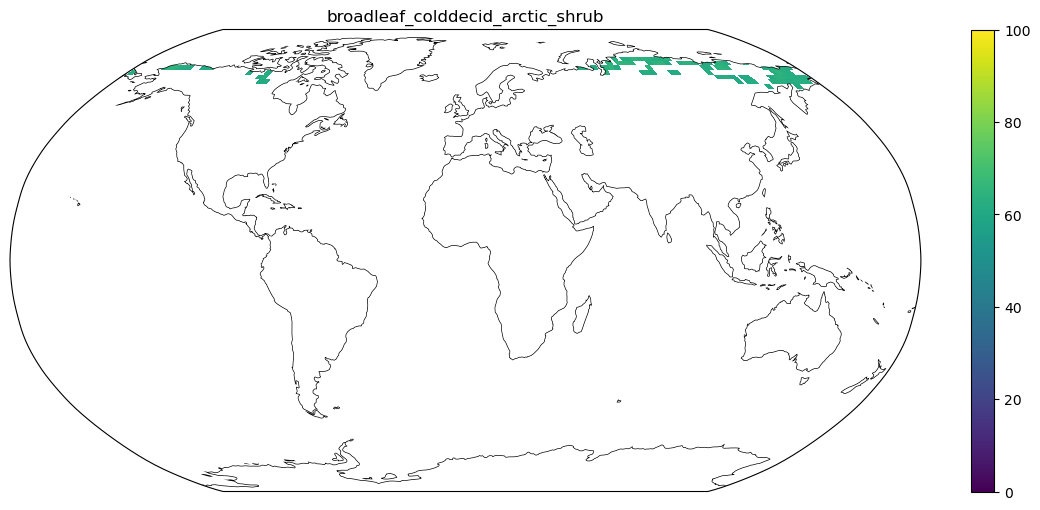

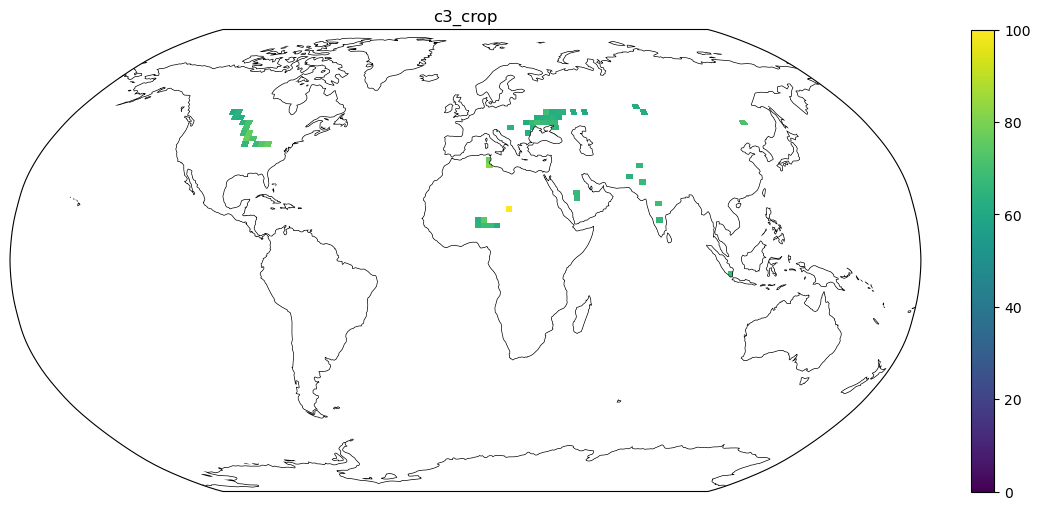

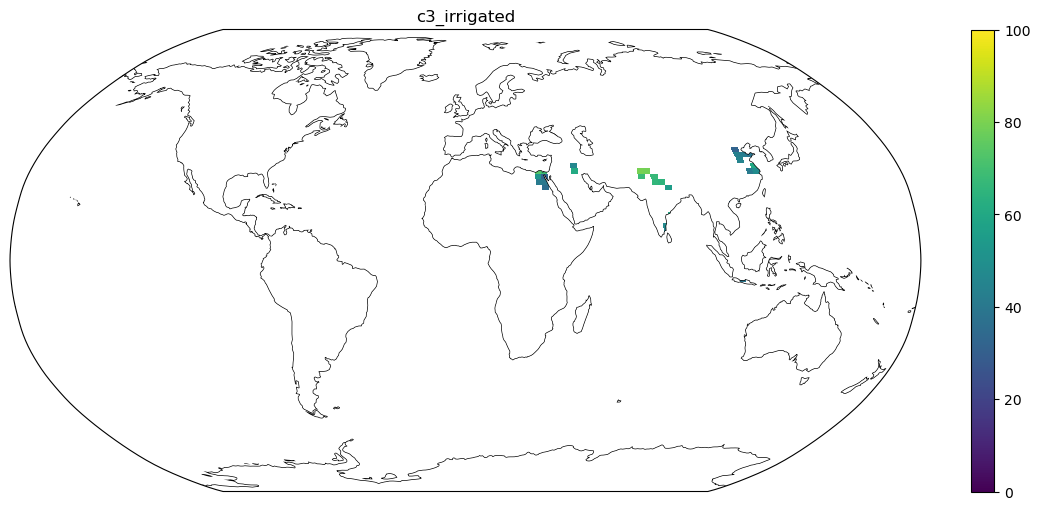

In [15]:
co_dom_grid = surface.extract_co_dominant_grids(surdat, lai, dom_pfts,
                                                fates_clm_mapping, dom_thresh)

### Filter on uncertain observations

In [18]:
co_dom_df = ilamb.extract_ilamb_obs(ILAMB_obs, co_dom_grid, biome, ilamb_config, 
                                      {'filter_vars': ['le', 'sh', 'gpp', 'ef'],
                                       'tol': 6.0})
co_dom_df.to_csv(os.path.join(out_dir, 'co-dominant_grid.csv'))

### Create the mask dataset

In [19]:
num_gridcells, surdat_codom = surface.create_mask_ds(surdat, co_dom_df, pft_names)
print(f"Made a surface dataset with {num_gridcells} gridcells")
surface.write_landmask(surdat_codom, out_dir, 'co-dominant')

Made a surface dataset with 325 gridcells


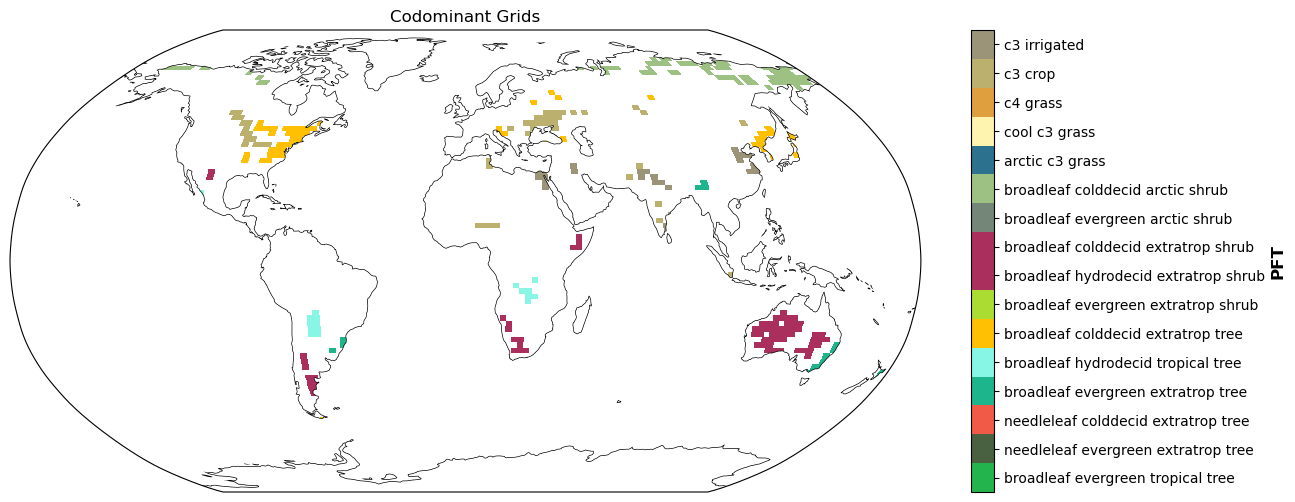

In [20]:
plotting.plot_pft_grids(surdat_codom, pft_names, "Codominant Grids")